# Multi-Scale Pyramid Motion Detection

This notebook extends the RANSAC-based motion detection with **multi-scale pyramid processing** to handle objects of different sizes without manual parameter tuning.

## Problem
Fixed hyperparameters (morphological kernel size, CC area thresholds) work for medium objects but fail for:
- **Small objects**: Get filtered out by morphology or min area threshold
- **Large objects**: May be split into multiple detections or exceed max area

## Solution
Process residuals at multiple scales with scale-normalized parameters:
- **Fine scale (1x)**: Catches small objects with small kernels/thresholds
- **Medium scale (0.5x)**: Catches medium objects
- **Coarse scale (0.25x)**: Catches large objects with large kernels/thresholds

Combine detections from all scales for complete coverage.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

In [2]:
# Configuration
VIDEO_PATH = 'data/videos/jets_1.mp4'
OUTPUT_DIR = 'data/multiscale_motion_frames'
PYRAMID_DIR = 'data/multiscale_pyramid_frames'

# Create output directories
for dir_path in [OUTPUT_DIR, PYRAMID_DIR]:
    Path(dir_path).mkdir(parents=True, exist_ok=True)

# Feature detection parameters (Shi-Tomasi)
feature_params = dict(
    maxCorners=200,
    qualityLevel=0.01,
    minDistance=30,
    blockSize=7
)

# Lucas-Kanade optical flow parameters
lk_params = dict(
    winSize=(21, 21),
    maxLevel=3,
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01)
)

# RANSAC parameters
RANSAC_REPROJ_THRESHOLD = 3.0

# Multi-scale pyramid parameters
NUM_PYRAMID_LEVELS = 3  # Number of scales to process
PYRAMID_SCALE_FACTOR = 0.5  # Each level is half the previous

# Base parameters (for finest scale)
BASE_THRESHOLD_SIGMA = 3.0
BASE_MORPH_KERNEL_SIZE = 3
BASE_MIN_AREA = 100
BASE_MAX_AREA = 50000

# Scale adjustment factors
THRESHOLD_SCALE_FACTOR = 1.3  # Threshold increases at coarser levels
KERNEL_SIZE_INCREMENT = 2  # Kernel grows by 2 each level

# Valid mask parameters
BORDER_MARGIN = 20

# Sampling
FRAME_SAMPLE_INTERVAL = 5

In [3]:
# ============================================
# Base functions (same as RANSAC approach)
# ============================================

def detect_features(gray):
    """Detect Shi-Tomasi features for tracking."""
    pts = cv2.goodFeaturesToTrack(gray, **feature_params)
    return pts


def track_features(prev_gray, curr_gray, prev_pts):
    """Track features using Lucas-Kanade optical flow."""
    if prev_pts is None or len(prev_pts) == 0:
        return None, None, None
    
    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(
        prev_gray, curr_gray, prev_pts, None, **lk_params
    )
    
    if status is not None:
        good_old = prev_pts[status.ravel() == 1]
        good_new = curr_pts[status.ravel() == 1]
        return good_old, good_new, status
    
    return None, None, None


def estimate_ego_motion_ransac(old_pts, new_pts):
    """Estimate camera ego-motion using RANSAC homography."""
    if old_pts is None or len(old_pts) < 4:
        return None, None
    
    H, inlier_mask = cv2.findHomography(
        old_pts, new_pts, cv2.RANSAC, RANSAC_REPROJ_THRESHOLD
    )
    return H, inlier_mask


def warp_frame(frame, H):
    """Warp frame using homography."""
    h, w = frame.shape[:2]
    warped = cv2.warpPerspective(frame, H, (w, h))
    return warped


def create_valid_warp_mask(warped_frame, border_margin=20):
    """Create mask of valid pixels after warping."""
    if len(warped_frame.shape) == 3:
        valid_mask = cv2.cvtColor(warped_frame, cv2.COLOR_BGR2GRAY) > 0
    else:
        valid_mask = warped_frame > 0
    
    valid_mask = valid_mask.astype(np.uint8) * 255
    
    # Erode to avoid edge artifacts
    erode_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    valid_mask = cv2.erode(valid_mask, erode_kernel)
    
    # Exclude borders
    if border_margin > 0:
        valid_mask[:border_margin, :] = 0
        valid_mask[-border_margin:, :] = 0
        valid_mask[:, :border_margin] = 0
        valid_mask[:, -border_margin:] = 0
    
    return valid_mask


def compute_residual(curr_gray, warped_prev_gray, valid_mask=None):
    """Compute residual after ego-motion compensation."""
    residual = cv2.absdiff(curr_gray, warped_prev_gray)
    
    if valid_mask is not None:
        residual = cv2.bitwise_and(residual, residual, mask=valid_mask)
    
    return residual

In [4]:
# ============================================
# Multi-Scale Pyramid Functions
# ============================================

def build_pyramid(image, num_levels):
    """
    Build Gaussian pyramid of an image.
    Level 0 = original resolution
    Level 1 = half resolution
    Level 2 = quarter resolution, etc.
    """
    pyramid = [image]
    current = image
    
    for i in range(1, num_levels):
        current = cv2.pyrDown(current)
        pyramid.append(current)
    
    return pyramid


def get_scale_params(level):
    """
    Get scale-normalized parameters for a pyramid level.
    
    Level 0 (finest): base parameters
    Level 1: scaled parameters for medium objects
    Level 2+: scaled parameters for large objects
    """
    # Threshold increases at coarser levels (less sensitive)
    threshold_sigma = BASE_THRESHOLD_SIGMA * (THRESHOLD_SCALE_FACTOR ** level)
    
    # Kernel size increases at coarser levels
    kernel_size = BASE_MORPH_KERNEL_SIZE + (KERNEL_SIZE_INCREMENT * level)
    # Ensure odd kernel size
    if kernel_size % 2 == 0:
        kernel_size += 1
    
    # Area thresholds scale quadratically (area = width * height)
    # At coarser levels, objects appear smaller in pixels
    scale_factor = (PYRAMID_SCALE_FACTOR ** level) ** 2  # Quadratic for area
    min_area = max(10, int(BASE_MIN_AREA * scale_factor))
    max_area = max(100, int(BASE_MAX_AREA * scale_factor))
    
    return {
        'threshold_sigma': threshold_sigma,
        'kernel_size': kernel_size,
        'min_area': min_area,
        'max_area': max_area
    }


def adaptive_threshold_mad(residual, valid_mask=None, sigma_multiplier=3.0):
    """
    Adaptive thresholding using Median Absolute Deviation (MAD).
    """
    if valid_mask is not None:
        valid_pixels = residual[valid_mask > 0]
    else:
        valid_pixels = residual.ravel()
    
    if len(valid_pixels) == 0:
        return np.zeros_like(residual, dtype=np.uint8), 15.0
    
    median_val = np.median(valid_pixels)
    mad = np.median(np.abs(valid_pixels.astype(np.float32) - median_val))
    mad_std = mad * 1.4826
    
    threshold = median_val + sigma_multiplier * mad_std
    threshold = max(threshold, 15)
    
    _, motion_mask = cv2.threshold(
        residual, threshold, 255, cv2.THRESH_BINARY
    )
    
    if valid_mask is not None:
        motion_mask = cv2.bitwise_and(motion_mask, motion_mask, mask=valid_mask)
    
    return motion_mask.astype(np.uint8), threshold


def morphological_cleanup(mask, kernel_size=5):
    """
    Apply morphological operations with specified kernel size.
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    
    # Close - fill small holes
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    # Open - remove small noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    return mask


def extract_bounding_boxes(mask, min_area=100, max_area=50000):
    """
    Extract bounding boxes using connected components.
    """
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
    
    detections = []
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        
        if min_area < area < max_area:
            x = stats[i, cv2.CC_STAT_LEFT]
            y = stats[i, cv2.CC_STAT_TOP]
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]
            centroid = tuple(map(int, centroids[i]))
            
            detections.append({
                'bbox': (x, y, w, h),
                'centroid': centroid,
                'area': area
            })
    
    return detections


def process_pyramid_level(residual, valid_mask, level):
    """
    Process a single pyramid level with scale-appropriate parameters.
    Returns detections at that scale (coordinates in that scale's space).
    """
    params = get_scale_params(level)
    
    # Downscale valid mask to match residual size at this level
    if valid_mask is not None:
        h, w = residual.shape[:2]
        valid_mask_scaled = cv2.resize(valid_mask, (w, h), interpolation=cv2.INTER_NEAREST)
    else:
        valid_mask_scaled = None
    
    # Threshold with scale-adjusted sigma
    motion_mask, thresh_val = adaptive_threshold_mad(
        residual, valid_mask_scaled, params['threshold_sigma']
    )
    
    # Morphological cleanup with scale-adjusted kernel
    motion_mask = morphological_cleanup(motion_mask, params['kernel_size'])
    
    # Extract detections with scale-adjusted area thresholds
    detections = extract_bounding_boxes(
        motion_mask, params['min_area'], params['max_area']
    )
    
    return detections, motion_mask, thresh_val, params


def scale_detections_to_original(detections, level):
    """
    Scale detections from pyramid level coordinates to original image coordinates.
    """
    scale = 1.0 / (PYRAMID_SCALE_FACTOR ** level)
    
    scaled_detections = []
    for det in detections:
        x, y, w, h = det['bbox']
        cx, cy = det['centroid']
        
        scaled_detections.append({
            'bbox': (
                int(x * scale),
                int(y * scale),
                int(w * scale),
                int(h * scale)
            ),
            'centroid': (int(cx * scale), int(cy * scale)),
            'area': int(det['area'] * scale * scale),
            'level': level
        })
    
    return scaled_detections


def merge_overlapping_detections(all_detections, iou_threshold=0.3):
    """
    Merge overlapping detections from different pyramid levels.
    Uses Non-Maximum Suppression (NMS) based on IoU.
    """
    if len(all_detections) == 0:
        return []
    
    # Convert to arrays for NMS
    boxes = []
    for det in all_detections:
        x, y, w, h = det['bbox']
        boxes.append([x, y, x + w, y + h])
    
    boxes = np.array(boxes, dtype=np.float32)
    
    # Score by area (larger detections preferred as they're more reliable)
    scores = np.array([det['area'] for det in all_detections], dtype=np.float32)
    
    # Apply NMS
    indices = cv2.dnn.NMSBoxes(
        boxes.tolist(),
        scores.tolist(),
        score_threshold=0.0,
        nms_threshold=iou_threshold
    )
    
    # Handle different OpenCV versions
    if len(indices) > 0:
        if isinstance(indices[0], (list, np.ndarray)):
            indices = [i[0] for i in indices]
        merged = [all_detections[i] for i in indices]
    else:
        merged = []
    
    return merged


def process_multiscale(residual, valid_mask, num_levels=3):
    """
    Main multi-scale processing function.
    
    1. Build pyramid of residual image
    2. Process each level with scale-appropriate parameters
    3. Scale detections back to original coordinates
    4. Merge overlapping detections across scales
    """
    # Build pyramid
    pyramid = build_pyramid(residual, num_levels)
    
    all_detections = []
    level_info = []
    
    for level, residual_scaled in enumerate(pyramid):
        # Process this level
        detections, mask, thresh, params = process_pyramid_level(
            residual_scaled, valid_mask, level
        )
        
        # Scale detections to original coordinates
        scaled_detections = scale_detections_to_original(detections, level)
        all_detections.extend(scaled_detections)
        
        level_info.append({
            'level': level,
            'shape': residual_scaled.shape,
            'params': params,
            'threshold': thresh,
            'detections': len(detections),
            'mask': mask
        })
    
    # Merge overlapping detections from different scales
    merged_detections = merge_overlapping_detections(all_detections)
    
    return merged_detections, level_info

In [5]:
# ============================================
# Visualization Functions
# ============================================

def draw_detections(frame, detections):
    """Draw bounding boxes with level info."""
    output = frame.copy()
    
    # Colors for different pyramid levels
    level_colors = [
        (0, 255, 0),    # Level 0: Green (fine scale)
        (0, 255, 255),  # Level 1: Yellow (medium scale)
        (0, 165, 255),  # Level 2: Orange (coarse scale)
        (0, 0, 255),    # Level 3+: Red
    ]
    
    for det in detections:
        x, y, w, h = det['bbox']
        level = det.get('level', 0)
        color = level_colors[min(level, len(level_colors) - 1)]
        
        cv2.rectangle(output, (x, y), (x + w, y + h), color, 2)
        cv2.circle(output, det['centroid'], 5, (0, 0, 255), -1)
        
        label = f"L{level} A:{det['area']}"
        cv2.putText(output, label, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    return output


def visualize_pyramid_levels(level_info, save_path=None):
    """
    Visualize detection masks at each pyramid level.
    """
    num_levels = len(level_info)
    fig, axes = plt.subplots(1, num_levels, figsize=(6 * num_levels, 6))
    
    if num_levels == 1:
        axes = [axes]
    
    for i, info in enumerate(level_info):
        axes[i].imshow(info['mask'], cmap='hot')
        axes[i].set_title(
            f"Level {info['level']}\n"
            f"Shape: {info['shape']}\n"
            f"Kernel: {info['params']['kernel_size']}\n"
            f"Detections: {info['detections']}"
        )
        axes[i].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150)
    
    plt.show()

In [6]:
# ============================================
# Main Processing Pipeline
# ============================================

def process_video_multiscale(video_path, num_levels=NUM_PYRAMID_LEVELS):
    """
    Process video with multi-scale pyramid motion detection.
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return
    
    ret, prev_frame = cap.read()
    if not ret:
        print("Error: Cannot read first frame")
        return
    
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    prev_pts = detect_features(prev_gray)
    
    frame_count = 0
    saved_count = 0
    
    print(f"Processing video with {num_levels}-level pyramid...")
    print(f"Scale parameters per level:")
    for level in range(num_levels):
        params = get_scale_params(level)
        print(f"  Level {level}: kernel={params['kernel_size']}, "
              f"min_area={params['min_area']}, max_area={params['max_area']}")
    print()
    
    while True:
        ret, curr_frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
        
        # Track features
        old_pts, new_pts, status = track_features(prev_gray, curr_gray, prev_pts)
        
        if old_pts is not None and len(old_pts) >= 4:
            # Estimate ego-motion with RANSAC
            H, inlier_mask = estimate_ego_motion_ransac(old_pts, new_pts)
            
            if H is not None:
                # Warp previous frame
                warped_prev_gray = warp_frame(prev_gray, H)
                
                # Create valid mask
                valid_mask = create_valid_warp_mask(warped_prev_gray, BORDER_MARGIN)
                
                # Compute residual
                residual = compute_residual(curr_gray, warped_prev_gray, valid_mask)
                
                # Multi-scale processing
                detections, level_info = process_multiscale(
                    residual, valid_mask, num_levels
                )
                
                # Save frames at intervals
                if frame_count % FRAME_SAMPLE_INTERVAL == 0:
                    # Draw results
                    output_frame = draw_detections(curr_frame, detections)
                    
                    # Save
                    cv2.imwrite(
                        f"{OUTPUT_DIR}/frame_{saved_count:04d}.png",
                        output_frame
                    )
                    
                    # Count detections per level
                    level_counts = {}
                    for det in detections:
                        lvl = det.get('level', 0)
                        level_counts[lvl] = level_counts.get(lvl, 0) + 1
                    
                    print(f"Frame {frame_count}: {len(detections)} detections "
                          f"(per level: {level_counts})")
                    saved_count += 1
        
        # Re-detect features periodically
        if frame_count % 10 == 0 or (new_pts is not None and len(new_pts) < 50):
            prev_pts = detect_features(curr_gray)
        else:
            prev_pts = new_pts.reshape(-1, 1, 2) if new_pts is not None else detect_features(curr_gray)
        
        prev_gray = curr_gray.copy()
    
    cap.release()
    print(f"\nProcessing complete. Saved {saved_count} frames.")
    print(f"Output saved to: {OUTPUT_DIR}")

In [7]:
# Run the multi-scale pipeline
process_video_multiscale(VIDEO_PATH, num_levels=3)

Processing video with 3-level pyramid...
Scale parameters per level:
  Level 0: kernel=3, min_area=100, max_area=50000
  Level 1: kernel=5, min_area=25, max_area=12500
  Level 2: kernel=7, min_area=10, max_area=3125

Frame 5: 1 detections (per level: {0: 1})
Frame 10: 1 detections (per level: {0: 1})
Frame 15: 2 detections (per level: {0: 2})
Frame 20: 3 detections (per level: {0: 3})
Frame 25: 1 detections (per level: {0: 1})
Frame 30: 1 detections (per level: {0: 1})
Frame 35: 1 detections (per level: {0: 1})
Frame 40: 1 detections (per level: {0: 1})
Frame 45: 1 detections (per level: {0: 1})
Frame 50: 1 detections (per level: {0: 1})
Frame 55: 1 detections (per level: {0: 1})
Frame 60: 0 detections (per level: {})
Frame 65: 1 detections (per level: {0: 1})
Frame 70: 1 detections (per level: {0: 1})
Frame 75: 1 detections (per level: {0: 1})
Frame 80: 2 detections (per level: {0: 2})
Frame 85: 1 detections (per level: {0: 1})
Frame 90: 2 detections (per level: {0: 2})
Frame 95: 2 de


Frame 30 Analysis:
Total detections (after merging): 1

Per-level breakdown:
  Level 0: (1024, 576) -> 1 raw detections, threshold=15.0
  Level 1: (512, 288) -> 1 raw detections, threshold=15.0
  Level 2: (256, 144) -> 0 raw detections, threshold=15.0


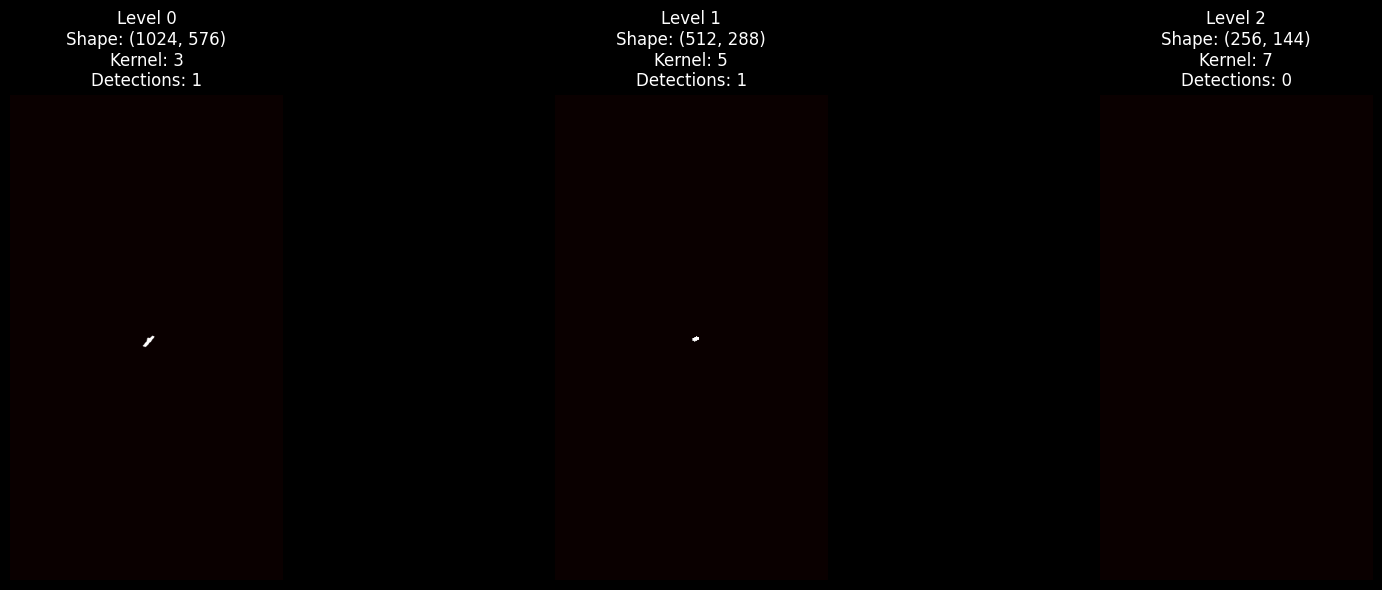

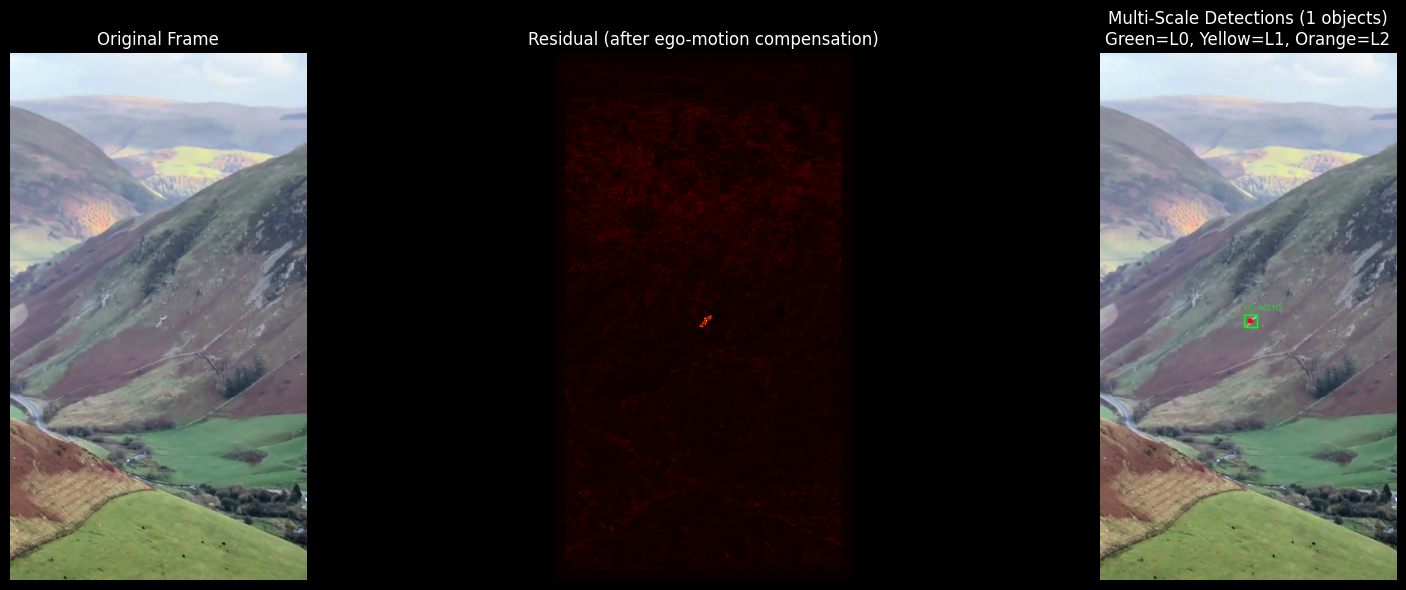

In [8]:
# ============================================
# Visualize pyramid levels for a single frame
# ============================================

def analyze_single_frame(video_path, frame_num=30, num_levels=3):
    """
    Analyze a single frame showing detections at each pyramid level.
    """
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num - 1)
    ret, prev_frame = cap.read()
    ret, curr_frame = cap.read()
    cap.release()
    
    if not ret:
        print(f"Cannot read frame {frame_num}")
        return
    
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    
    # Track and estimate motion
    prev_pts = detect_features(prev_gray)
    old_pts, new_pts, _ = track_features(prev_gray, curr_gray, prev_pts)
    
    if old_pts is None or len(old_pts) < 4:
        print("Not enough tracked points")
        return
    
    H, _ = estimate_ego_motion_ransac(old_pts, new_pts)
    
    if H is None:
        print("Could not estimate homography")
        return
    
    # Compute residual
    warped_prev = warp_frame(prev_gray, H)
    valid_mask = create_valid_warp_mask(warped_prev, BORDER_MARGIN)
    residual = compute_residual(curr_gray, warped_prev, valid_mask)
    
    # Multi-scale processing
    detections, level_info = process_multiscale(residual, valid_mask, num_levels)
    
    # Visualize
    print(f"\nFrame {frame_num} Analysis:")
    print(f"Total detections (after merging): {len(detections)}")
    print(f"\nPer-level breakdown:")
    for info in level_info:
        print(f"  Level {info['level']}: {info['shape']} -> "
              f"{info['detections']} raw detections, "
              f"threshold={info['threshold']:.1f}")
    
    # Show pyramid masks
    visualize_pyramid_levels(level_info, f"{PYRAMID_DIR}/pyramid_frame_{frame_num}.png")
    
    # Show final result
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(cv2.cvtColor(curr_frame, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Frame')
    axes[0].axis('off')
    
    axes[1].imshow(residual, cmap='hot')
    axes[1].set_title('Residual (after ego-motion compensation)')
    axes[1].axis('off')
    
    output = draw_detections(curr_frame, detections)
    axes[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axes[2].set_title(f'Multi-Scale Detections ({len(detections)} objects)\n'
                      'Green=L0, Yellow=L1, Orange=L2')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/analysis_frame_{frame_num}.png", dpi=150)
    plt.show()

# Analyze a specific frame
analyze_single_frame(VIDEO_PATH, frame_num=30, num_levels=3)

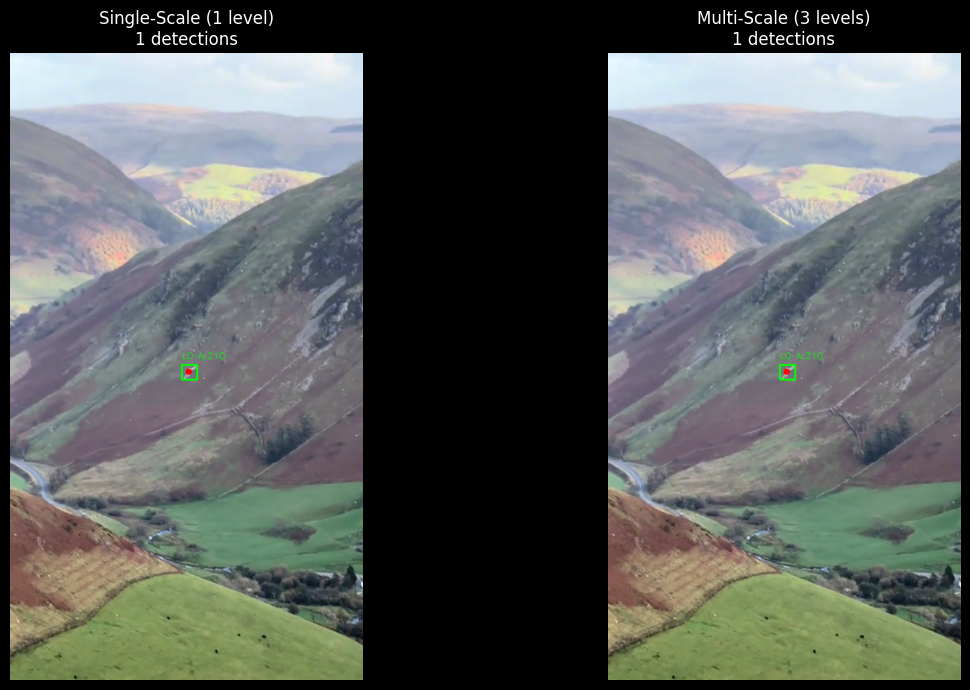

Single-scale: 1 detections
Multi-scale: 1 detections


In [9]:
# ============================================
# Compare single-scale vs multi-scale
# ============================================

def compare_single_vs_multiscale(video_path, frame_num=30):
    """
    Compare single-scale (original approach) vs multi-scale detection.
    """
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num - 1)
    ret, prev_frame = cap.read()
    ret, curr_frame = cap.read()
    cap.release()
    
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    
    prev_pts = detect_features(prev_gray)
    old_pts, new_pts, _ = track_features(prev_gray, curr_gray, prev_pts)
    H, _ = estimate_ego_motion_ransac(old_pts, new_pts)
    
    warped_prev = warp_frame(prev_gray, H)
    valid_mask = create_valid_warp_mask(warped_prev, BORDER_MARGIN)
    residual = compute_residual(curr_gray, warped_prev, valid_mask)
    
    # Single-scale (level 0 only)
    single_detections, _ = process_multiscale(residual, valid_mask, num_levels=1)
    
    # Multi-scale (3 levels)
    multi_detections, _ = process_multiscale(residual, valid_mask, num_levels=3)
    
    # Visualize comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    single_output = draw_detections(curr_frame, single_detections)
    axes[0].imshow(cv2.cvtColor(single_output, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f'Single-Scale (1 level)\n{len(single_detections)} detections')
    axes[0].axis('off')
    
    multi_output = draw_detections(curr_frame, multi_detections)
    axes[1].imshow(cv2.cvtColor(multi_output, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'Multi-Scale (3 levels)\n{len(multi_detections)} detections')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/single_vs_multi_frame_{frame_num}.png", dpi=150)
    plt.show()
    
    print(f"Single-scale: {len(single_detections)} detections")
    print(f"Multi-scale: {len(multi_detections)} detections")

compare_single_vs_multiscale(VIDEO_PATH, frame_num=30)

## How Multi-Scale Pyramid Works

### The Scale Problem
With fixed parameters:
- Small objects get erased by morphological operations (kernel too big)
- Small objects fall below `MIN_OBJECT_AREA` threshold
- Large objects may exceed `MAX_OBJECT_AREA` or get split

### The Solution
Process at multiple resolutions where parameters automatically scale:

| Level | Resolution | Kernel | Min Area | Best For |
|-------|------------|--------|----------|----------|
| 0 | 100% | 3×3 | 100 px | Small objects |
| 1 | 50% | 5×5 | 25 px | Medium objects |
| 2 | 25% | 7×7 | 6 px | Large objects |

### Parameter Scaling Rules
- **Kernel size**: `base + 2×level` (3→5→7→9)
- **Area thresholds**: Scale quadratically (`÷4` per level)
- **Threshold sigma**: Increases slightly at coarser levels

### Detection Merging
Objects detected at multiple scales are merged using Non-Maximum Suppression (NMS) with IoU threshold. This prevents duplicate detections of the same object.

### Color Coding
- **Green**: Detected at Level 0 (fine scale - small objects)
- **Yellow**: Detected at Level 1 (medium scale)
- **Orange**: Detected at Level 2 (coarse scale - large objects)